In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib.fl_model_v9 import *
import pygmo as pg

# Notes

Ending note: It could be that over time, hypervolumes donnot increase. It's "unfair" to compare hypervolumes over different periods. This is because cost will increase over time, while the others will decrease over time.

XX If time and if possible: Do the whole analysis, while leaving out costs

#  Code

In [3]:
case = "Nepal"
output_folder = "MPMORDM Results v1 2015"

In [4]:
# Load data (deserialize)
with open('{}/{}/python_objects.pickle'.format(case, output_folder),
          'rb') as handle:
    global_label_tree, EMA_model_dict, global_dfs_var_unc_data, global_fixed_unc, global_policy_tree = pickle.load(
        handle)

In [5]:
# For period x, get all resulting policies

In [6]:
def find_nodes_next_step(node,label_tree):
    # Find which period
    for i,l in enumerate(reversed(node)):
        if l == 'p':
            period = int((list(reversed(node))[i-1]))
            break
    # Find next period
    labels_next_p = label_tree["p{}".format(period+1)]
#     print(labels_next_p)
    return [l for l in labels_next_p if node in l]

find_nodes_next_step('p0n0p1n2', global_label_tree)

['p0n0p1n2p2n14', 'p0n0p1n2p2n15', 'p0n0p1n2p2n16', 'p0n0p1n2p2n17']

In [7]:
def get_mordm_resulting_policies(node, label_tree, policy_tree):
    # Get all labels of resulting mordm cycle
    labels = find_nodes_next_step(node,label_tree)
    # Get all policies for these labels
    policies = [policy_tree[label] for label in labels] 
    return policies

# get_mordm_resulting_policies("p0n0", global_label_tree, global_policy_tree)

In [8]:
def get_all_mordms_in_period(period, label_tree, policy_tree):
    nodes = label_tree[period]
    mordm_results = [get_mordm_resulting_policies(node,label_tree,policy_tree) for node in nodes]
    return mordm_results

# get_all_mordms_in_period("p1",global_label_tree,global_policy_tree)

In [9]:
p1_mordm_pol_sets = get_all_mordms_in_period("p1", global_label_tree,
                                             global_policy_tree)

In [10]:
# For all policies, evaluate on real values

In [11]:
DPs = pd.read_csv("Nepal/Prepared Input Data/DPs.csv")
# DPs.columns

FLs = pd.read_csv("Nepal/Prepared Input Data/FLs.csv")
# FLs.columns

SPs = pd.read_csv("Nepal/Prepared Input Data/SPs.csv")
# SPs.columns
Fix_Unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case), index_col=0)
# Fix_Unc

In [12]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}
# DPpop = {"DPpop{}".format(i): random.uniform(10,100) for i in range(nr_of_DPs)}

In [13]:
epicentre_name = "RealLocation"
disruptionsFLs = np.loadtxt(
    '{}/Prepared Input Data/DisruptionFL{}.txt'.format(case,epicentre_name))
disruptionsDPs = np.loadtxt(
    '{}/Prepared Input Data/DisruptionDP{}.txt'.format(case,epicentre_name))

DSRDP = {"DSRDP{}".format(i): 1.5 for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): 1.5 for i in range(len(FLX))}

In [14]:
def evaluate_pol_set(pol_set):
    results = []
    for policy in pol_set:
        results.append(FL_model(
            unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
            FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))
    return results

In [15]:
evaluate_pol_set(test_pol_set)

NameError: name 'test_pol_set' is not defined

In [16]:
def get_branch_performance(period, label_tree, policy_tree):
    p_mordm_pol_sets = get_all_mordms_in_period(period, label_tree,
                                                policy_tree)
    result_sets = []
    for pol_set in p_mordm_pol_sets:
        result_sets.append(evaluate_pol_set(pol_set))
    return result_sets

In [17]:
sets = get_branch_performance('p1',global_label_tree,global_policy_tree)

In [18]:
# For each mordm cycle, calculate hypervolume

In [19]:
# normalise_df(df)

In [20]:
def normalise_df (df):
    normalised_df=(df-df.min())/(df.max()-df.min())
    return normalised_df

In [21]:
def normalise_sets(all_sets):
    df = pd.DataFrame()
    for i, s in enumerate(all_sets):
        dftemp = pd.DataFrame(s)
        dftemp['set'] = i
        df = df.append(dftemp)
    df = df.reset_index(drop=True)
    df_normalised = normalise_df(df.iloc[:, :4])
    df_normalised['set'] = df['set']

    sets_normalised = []
    for i in sorted(list(set(df_normalised.set))):
        sets_normalised.append(df_normalised[df_normalised.set == i].values)
    return sets_normalised

In [22]:
# df = pd.DataFrame()
# for i,s in enumerate(sets):
#     dftemp = pd.DataFrame(s)
#     dftemp['set']=i
#     df = df.append(dftemp)
    
# sets

In [23]:
df = df.reset_index(drop=True)

NameError: name 'df' is not defined

In [24]:
df_normalised = normalise_df(df.iloc[:,:4])

NameError: name 'df' is not defined

In [25]:
df_normalised['set'] = df['set']

NameError: name 'df' is not defined

In [26]:
df_normalised.head(1)

NameError: name 'df_normalised' is not defined

In [27]:
sets_normalised = []
for i in sorted(list(set(df_normalised.set))):
    sets_normalised.append(df_normalised[df_normalised.set == i].values)

NameError: name 'df_normalised' is not defined

In [28]:
# sets_normalised

In [29]:
def compute_hypervolumes(normalised_sets):
    ref_point = [1,1,1,1]
    hvs = []
    for tmpset in normalised_sets:
        hv = pg.hypervolume(tmpset.astype(float)[:,:4])
        hvs.append(hv.compute(ref_point))
    return hvs

In [30]:
a = compute_hypervolumes(sets_normalised)

In [31]:
# For each mordm cycle, calculate uncertainty space.

In [32]:
def get_uncertainty_bandwiths(period,
                              label_tree,
                              var_unc_data,
                              function="mean"):
    """
    period: string: E.g. "p0"
    function: string. function to perform on pandas Series.
        E.g.: mean, max, min
    """
    p_labels = label_tree[period]
    bandwidth_metrics = []
    for l in p_labels:
        bandwith = (var_unc_data[l].upper - var_unc_data[l].lower)
        metric = eval("bandwith.{}()".format(function))
#         print(l)
#         print(bandwith)
        bandwidth_metrics.append(metric)
    return bandwidth_metrics

In [33]:
b = get_uncertainty_bandwiths("p1",global_label_tree,global_dfs_var_unc_data)

ValueError: x and y must be the same size

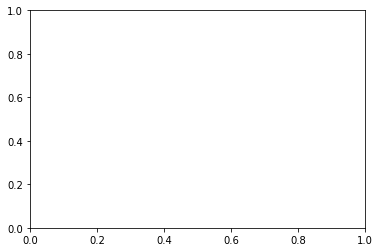

In [34]:
# Plot single period in scatter
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(a,b)
# ax.scatter(b,a)

plt.show()

In [35]:
sorted(global_label_tree.keys())[:-1]

['p0', 'p1', 'p2', 'p3']

p0
p1
p2
p3


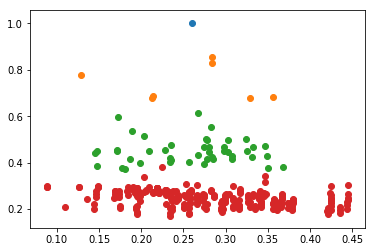

In [39]:
# Do all this for all periods.

fig = plt.figure()
ax = fig.add_subplot(111)
for period in sorted(global_label_tree.keys())[:-1]:
    print(period)
    # period = "p1"

    sets = get_branch_performance(period, global_label_tree,
                                  global_policy_tree)

    sets_normalised = normalise_sets(sets)

    hvs = compute_hypervolumes(sets_normalised)

    bws = get_uncertainty_bandwiths(period, global_label_tree,
                                    global_dfs_var_unc_data)
    
    ax.scatter(hvs,bws)
plt.show()

* Splits uit. Kijk wanneer punten rechts liggen, kijk wanneer punten links liggen
* Doe dit niet alleen voor hypervolumes, maar ook voor scores individuele objectives
* Kijk bijvoorbeeld naar wat er gebeurt als je kleuren doet op basis van scores op individuele objectives
* Gebruik Plotly voor makkelijk kleur en interactief maken

Bottomline: 
- Find reason for convergence on hypervolume indicator. Is because of what?
- Apparently no correlation between hypervolume and uncertainty reduction. what is then correlated to uncertainty reduction? I guess covered demand the most. Find this for valuable insight!!XXXX

Alse:
- Do PRIM on objectives (for every period) to see how they affect uncertainty & performance (hv)

In [37]:
data = pd.DataFrame([hvs,bws]).T
data.columns = ['hvs', 'unc_bws']

<b>Regression Plot</b><br>
Here we see a slight correlation between bandwidth and uncertainty. 
When Uncertainty decrease, hypervolumes increase. Although it seems there are other more important, which will be looked for onwards. 

This relation is obvious: When using better best estimates for the optimisation, the results will be better. Variability can probably be explained by the different valuations of objectives over time. (Hypothesis: focus on minimisation of cost at any point in time will reduce final hypervolume) 

C:\Users\timro\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


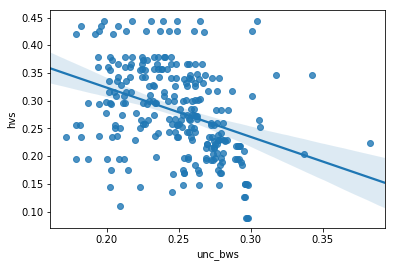

In [38]:
import seaborn as sns
sns.regplot(y='hvs',x='unc_bws', data=data)

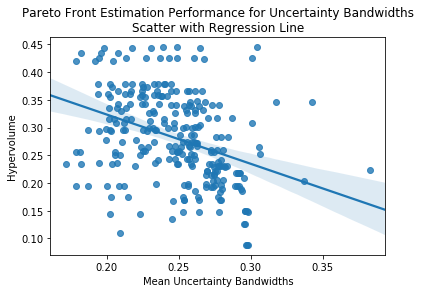

In [707]:
data = pd.DataFrame([hvs, bws]).T
data.columns = ['hvs', 'unc_bws']
import seaborn as sns

ax = sns.regplot(y='hvs', x='unc_bws', data=data)
ax.set(
    xlabel='Mean Uncertainty Bandwidths',
    ylabel="Hypervolume",
    title="Pareto Front Estimation Performance for Uncertainty Bandwidths\nScatter with Regression Line")
plt.savefig("{}/{}/Analysis/HVxUNC".format(case, output_folder), dpi=500)

In [345]:
data.columns

Index(['hvs', 'unc_bws'], dtype='object')

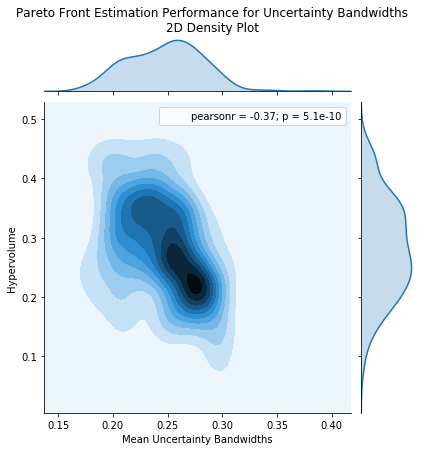

In [45]:
ax = sns.jointplot(
    y=data['hvs'],
    x=data['unc_bws'],
    kind='kde',
)
# ax.set(
#     xlabel='Mean Uncertainty Bandwidths',
#     ylabel="Hypervolume",
#     title="Pareto Front Estimation Performance for Uncertainty Bandwidths\n2D Density Plot")
ax.fig.suptitle(
    "Pareto Front Estimation Performance for Uncertainty Bandwidths\n2D Density Plot",
    y=1.04)
ax.set_axis_labels('Mean Uncertainty Bandwidths', "Hypervolume")
plt.savefig(
    "{}/{}/Analysis/HVxUNC-Density".format(case, output_folder), dpi=500, bbox_inches='tight')

In [9]:
# Plot all in single scatter, different colors for different periods

In [10]:
# Connect each point with the related points in previous timesteps.

# Correlate hypervolumes and uncertainties

Check if policies always in same order. Otherwise, not the right points connected to each other.

if so. Then Get best estimate objective evaluations

In [400]:
a = get_branch_performance('p3', global_label_tree,
                                  global_policy_tree)
# b = normalise_sets(a)

# c = compute_hypervolumes(sets_normalised)

# d = get_uncertainty_bandwiths('p4', global_label_tree,
#                                     global_dfs_var_unc_data)

In [389]:
# b = get_branch_pols('p3', global_label_tree,
#                                   global_policy_tree)

In [360]:
# def get_branch_pols(period, label_tree, policy_tree):
#     p_mordm_pol_sets = get_all_mordms_in_period(period, label_tree,
#                                                 policy_tree)

#     return p_mordm_pol_sets

In [401]:
len(a)

268

In [404]:
len(global_label_tree['p3'])

268

In [406]:
len(hvs)

268

In [407]:
global_label_tree['p3'][0]

'p0n0p1n1p2n8p3n53'

In [410]:
labelname = global_label_tree['p3'][0]
pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, labelname))

,Unnamed: 0,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
0,3,121595.612894,14.0,9582.396048,57150.213923
1,13,271735.281291,12.0,8144.452546,57150.213923
2,16,124693.285242,13.0,9570.863418,57150.213923
3,19,275848.344199,13.0,9380.077284,38755.495023


In [413]:
labelname = global_label_tree['p3'][0]
labelname[:-5]

'p0n0p1n1p2n8'

In [414]:
labelname = 'p0n0p1n1p2n8'
pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, labelname))

,Unnamed: 0,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
0,11,283650.216833,14.0,8617.445500,58540.936826
1,13,259715.674729,15.0,9828.298716,58540.936826
2,14,97782.715426,18.0,11919.500324,58540.936826
3,16,101317.480922,17.0,11908.632693,58540.936826
4,19,74123.054817,27.0,33358.820149,68030.764552


In [422]:
global_policy_tree[global_label_tree['p3'][0]]

{'FLO0': 0.0,
 'FLO1': 0.0,
 'FLO2': 0.0,
 'FLO3': 0.0,
 'FLO4': 1.0,
 'FLO5': 0.0,
 'FLO6': 0.0,
 'FLO7': 1.0,
 'FLO8': 0.0,
 'FLO9': 0.0,
 'FLO10': 0.0,
 'FLO11': 1.0,
 'FLO12': 0.0,
 'FLO13': 0.0,
 'FLO14': 0.0,
 'FLO15': 0.0,
 'FLO16': 0.0,
 'FLO17': 0.0,
 'FLO18': 0.0,
 'FLO19': 0.0}

In [448]:
label0 = global_label_tree['p3'][0]
labelprev = find_previous_label(global_label_tree['p3'][0])

In [451]:
def find_previous_label(label):
    for i,l in enumerate(label[::-1]):
        if l == "p":
            return label[:-i-1]
#test
find_previous_label(label0)

'p0n0p1n1p2n8'

In [461]:

prev_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, labelprev), index_col=0)
prev_perf

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
11,283650.216833,14.0,8617.445500,58540.936826
13,259715.674729,15.0,9828.298716,58540.936826
14,97782.715426,18.0,11919.500324,58540.936826
16,101317.480922,17.0,11908.632693,58540.936826
19,74123.054817,27.0,33358.820149,68030.764552


In [457]:
def policy_to_fls(pol):
    return [int(key[3:]) for key, val in pol.items() if val == 1]

In [464]:
temp_fls = policy_to_fls(global_policy_tree[label0])
temp_fls

[4, 7, 11]

In [ ]:
def return_performance ()

In [468]:
for fl in temp_fls:
    if fl in prev_perf.index:
        perf = prev_perf.loc[fl]

In [469]:
perf

total_costs               283650.216833
nr_uncovered_DPs              14.000000
total_uncovered_demand      8617.445500
max_distr_time             58540.936826
Name: 11, dtype: float64

In [477]:
def find_previous_performance(label, objective=None):
    prev_label = find_previous_label(label)
    prev_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, prev_label), index_col=0)
    cur_pol = global_policy_tree[label]
    cur_fls = policy_to_fls(cur_pol)
    for fl in cur_fls:
        if fl in prev_perf.index:
            if objective == None:
                return prev_perf.loc[fl]
            else:
                return prev_perf.loc[fl][objective]
    raise ValueError("Something went wrong")

In [472]:
label0

'p0n0p1n1p2n8p3n53'

In [481]:
find_previous_performance(label0, objective='total_costs')

283650.2168326702

In [504]:
def find_label_at_p(label, p='p1'):
    for i,l in enumerate(label):
        if p in label[i:i+2]:
            last_p_i = i
    remaining = label[last_p_i+1:]
    for i,l in enumerate(remaining):
        if l == 'p':
            return label[:i+last_p_i+1]

find_label_at_p('p0n0p1n7p2n50p3n307')

'p0n0p1n7'

In [532]:
# def find_originating_performance(label, objective=None, period='p0'):
# #     only change is the get prev perf. should be changed: find label
#     orig_label = find_label_at_p(label, period)
#     orig_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, orig_label), index_col=0)
#     cur_pol = global_policy_tree[label]
#     cur_fls = policy_to_fls(cur_pol)
#     for fl in cur_fls:
#         if fl in orig_perf.index:
#             if objective == None:
#                 return orig_perf.loc[fl]
#             else:
#                 return orig_perf.loc[fl][objective]
#     raise ValueError("Something went wrong")

In [509]:
label0

'p0n0p1n1p2n8p3n53'

In [511]:
# BUG!!
find_originating_performance('p0n0p1n7p2n50p3n307', objective='total_costs')

191454.8491945833

In [531]:
def find_last_fl(label):
    prev_label = find_previous_label(label)
    prev_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, prev_label), index_col=0)
    cur_pol = global_policy_tree[label]
    cur_fls = policy_to_fls(cur_pol)
    for fl in cur_fls:
        if fl in prev_perf.index:
            return fl, prev_label
    raise ValueError("Something went wrong")

find_last_fl("p0n0p1n1p2n8p3n53")

(11, 'p0n0p1n1p2n8')

In [527]:
def find_fl_placement_sequence(label):
    """verificated"""
    max_ps = label.count("p")-1
    sequence = []
    cur_label = label
    while len(sequence) < max_ps:
        last_fl, prev_label = find_last_fl(cur_label)
        sequence.append(last_fl)
        cur_label = prev_label
    return list(reversed(sequence))
    
    

In [530]:
find_fl_placement_sequence("p0n0p1n7p2n50p3n307")

[19, 13, 16]

In [534]:
test = 'p0n0p1n7p2n50p3n307'

In [601]:
def find_originating_performance(label, objective=None, period='p0'):
    """Verificated"""
    orig_label = find_label_at_p(label, period)
    orig_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, orig_label), index_col=0)
    period_i = int(period[1])
    
    fl_sequence = find_fl_placement_sequence(label)
    fl = fl_sequence[period_i]
#     print(fl,orig_label)
    if objective == None:
        return orig_perf.loc[fl]
    else:
        return orig_perf.loc[fl][objective]
    raise ValueError("Something went wrong")

In [627]:
test='p0n0p1n1p2n8p3n53p4n321'
print(find_originating_performance(test, period='p0', objective='total_costs'))
print(find_originating_performance(test, period='p1', objective='total_costs'))
print(find_originating_performance(test, period='p2', objective='total_costs'))
print(find_originating_performance(test, period='p3', objective='total_costs'))

72927.06147041668
68413.04592642689
283650.2168326702
121595.61289414324


In [545]:
# global_policy_tree['p0n0p1n7p2n50p3n307']

In [619]:
p4labels=global_label_tree['p4']

In [620]:
len(p4labels)

1376

In [621]:
find_originating_performance('p0n0p1n1p2n8p3n53p4n321', objective="total_costs", period='p0')

72927.06147041668

In [622]:
uncertainty_bandwidths_p4 = get_uncertainty_bandwiths("p4", global_label_tree, global_dfs_var_unc_data, function="mean")

In [624]:
len(uncertainty_bandwidths_p4)

1376

In [626]:
df1 = pd.DataFrame([uncertainty_bandwidths_p4,p4labels]).T
df1.head()

,0,1
0,0.107047,p0n0p1n1p2n8p3n53p4n321
1,0.107039,p0n0p1n1p2n8p3n53p4n322
2,0.117679,p0n0p1n1p2n8p3n53p4n323
3,0.104997,p0n0p1n1p2n8p3n54p4n324
4,0.105065,p0n0p1n1p2n8p3n54p4n325


In [635]:
p3_performances = df1.apply(
    lambda row: find_originating_performance(row[1], period='p3'), axis=1)

In [774]:
p3_performance_unc_range = pd.concat([df1,p3_performances], axis=1)

p3_performance_unc_range.columns = [
    'uncertainty', 'label', 'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_distr_time'
]

p3_performance_unc_range = p3_performance_unc_range.set_index('label')
p3_performance_unc_range = p3_performance_unc_range.astype(float)
p3_performance_unc_range.head()

,uncertainty,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
label,,,,,
p0n0p1n1p2n8p3n53p4n321,0.107047,121595.612894,14.0,9582.396048,57150.213923
p0n0p1n1p2n8p3n53p4n322,0.107039,124693.285242,13.0,9570.863418,57150.213923
p0n0p1n1p2n8p3n53p4n323,0.117679,275848.344199,13.0,9380.077284,38755.495023
p0n0p1n1p2n8p3n54p4n324,0.104997,119563.645948,15.0,10312.280512,57150.213923
p0n0p1n1p2n8p3n54p4n325,0.105065,122664.847174,14.0,10300.608346,57150.213923


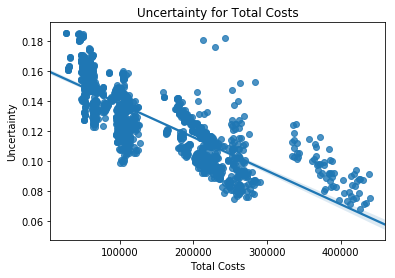

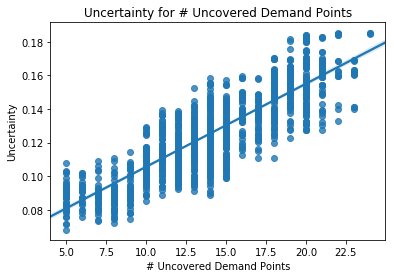

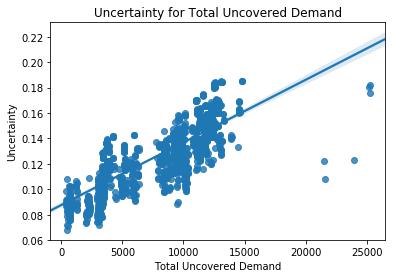

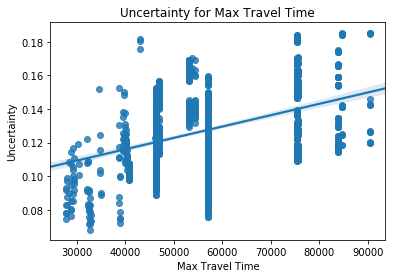

In [727]:
objectives = [
    'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_distr_time'
]
objectives_nice = [
    'Total Costs', '# Uncovered Demand Points', 'Total Uncovered Demand',
    'Max Travel Time'
]
for obj, obj_nice in zip(objectives, objectives_nice):
    ax = sns.regplot(
        y=p3_performance_unc_range['uncertainty'],
        x=p3_performance_unc_range[obj],
        fit_reg=True)
    ax.set(title = "Uncertainty for {}".format(obj_nice),
           xlabel = obj_nice,
           ylabel = "Uncertainty"
          )
#     ax.suptitle()
#     ax.set_axis_labels(, "Uncertainty")
    #     plt.show()
    plt.savefig(
        "{}/{}/Analysis/Uncertainty for {}".format(case, output_folder,
                                                   obj_nice),
        dpi=500,
        bbox_inches='tight')
    plt.show()

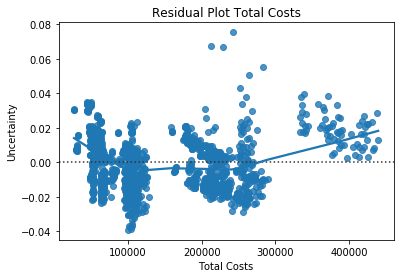

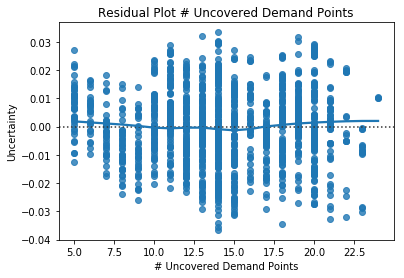

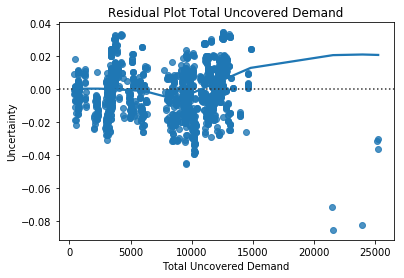

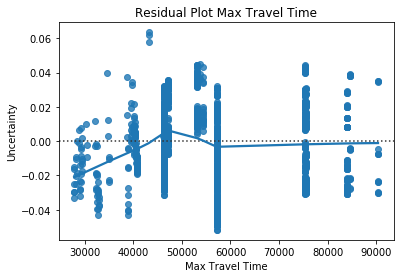

In [737]:
for obj, obj_nice in zip(objectives, objectives_nice):
    ax = sns.residplot(
        y=p3_performance_unc_range['uncertainty'],
        x=p3_performance_unc_range[obj], lowess=True)
#     plt.show()
    ax.set(title = "Residual Plot {}".format(obj_nice),
           xlabel = obj_nice,
           ylabel = "Uncertainty"
          )
#     ax.suptitle()
#     ax.set_axis_labels(, "Uncertainty")
    #     plt.show()
    plt.savefig(
        "{}/{}/Analysis/Residual Plot {}".format(case, output_folder,
                                                   obj_nice),
        dpi=500,
        bbox_inches='tight')
    plt.show()

## Regression analysis

In [659]:
p3_performance_unc_range.head(1)

,uncertainty,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
label,,,,,
p0n0p1n1p2n8p3n53p4n321,0.107047,121595.612894,14.0,9582.396048,57150.213923


In [657]:
p3_performance_unc_range

In [678]:
from scipy import stats
y = np.array(p3_performance_unc_range['uncertainty']).astype(float)
total_cost = np.array(p3_performance_unc_range['total_costs']).astype(float)

In [685]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope:", slope, '\nintercept', intercept, '\nr2', r_value**2,
      '\np_value', p_value, '\nstd_err', std_err)

slope: -2.2314319687926345e-07 
intercept 0.16041529770385182 
r2 0.6506253658887836 
p_value 4.64733878e-316 
std_err 4.4113394121132184e-09


In [801]:
for obj in objectives:
    y = np.array(p3_performance_unc_range['uncertainty']).astype(float)
    x = np.array(p3_performance_unc_range[obj]).astype(float)
    print(obj, ":")
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print("slope:", slope, '\nintercept:', intercept, '\nr2:', r_value**2,
          '\np_value:', p_value, '\nstd_err:', std_err)
    print("")

total_costs :
slope: -2.2314319687926345e-07 
intercept: 0.16041529770385182 
r2: 0.6506253658887836 
p_value: 4.64733878e-316 
std_err: 4.4113394121132184e-09

nr_uncovered_DPs :
slope: 0.0049461799805141865 
intercept: 0.056083896112613274 
r2: 0.7258065381047022 
p_value: 0.0 
std_err: 8.201525856157067e-05

total_uncovered_demand :
slope: 4.9302217732543495e-06 
intercept: 0.087569755765229 
r2: 0.6290300556074 
p_value: 3.707234637042345e-298 
std_err: 1.0214256343376718e-07

max_distr_time :
slope: 6.758461205384558e-07 
intercept: 0.08900517058221273 
r2: 0.1453928316943145 
p_value: 7.470804167345761e-49 
std_err: 4.420447398290312e-08



## Multiple Regression

In [742]:
import statsmodels.api as sm

In [795]:
x = p3_performance_unc_range[objectives]
y = p3_performance_unc_range['uncertainty']
x = sm.add_constant(x)


In [796]:
model = sm.OLS(y,x).fit()

In [797]:
predictions = model.predict(x)

In [798]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            uncertainty   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1613.
Date:                Fri, 15 Jun 2018   Prob (F-statistic):               0.00
Time:                        17:35:05   Log-Likelihood:                 4312.1
No. Observations:                1376   AIC:                            -8614.
Df Residuals:                    1371   BIC:                            -8588.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0581      0.003     19.952      0.000       0.052       0.064
total_costs            -5.139e-08   6.32e-09     -8.132      0.000   -6.38e-08    -3.9e-08
nr_uncovered_DPs           0.0021      0.000     11.408      0.000       0.002       0.002
total_uncovered_demand  1.946e-06   1.98e-07      9.829      0.000    1.56e-06    2.33e-06
max_distr_time          5.425e-07   2.24e-08     24.186      0.000    4.99e-07    5.87e-07
==============================================================================
Omnibus:                        0.927   Durbin-Watson:                   0.868
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.866
Skew:                           0.060   Prob(JB):                        0.649
Kurtosis:                       3.030   Cond. No.                     1.85e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [738]:
p3_performance_unc_range.head()

,uncertainty,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
label,,,,,
p0n0p1n1p2n8p3n53p4n321,0.107047,121595.612894,14.0,9582.396048,57150.213923
p0n0p1n1p2n8p3n53p4n322,0.107039,124693.285242,13.0,9570.863418,57150.213923
p0n0p1n1p2n8p3n53p4n323,0.117679,275848.344199,13.0,9380.077284,38755.495023
p0n0p1n1p2n8p3n54p4n324,0.104997,119563.645948,15.0,10312.280512,57150.213923
p0n0p1n1p2n8p3n54p4n325,0.105065,122664.847174,14.0,10300.608346,57150.213923
